In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [3]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])


In [4]:
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,9999.998732,0.996949,0.134761,10000.001268
1,9999.996849,0.997237,0.134800,10000.003151
2,9999.994966,0.997245,0.134802,10000.005034
3,9999.993083,0.996937,0.134760,10000.006917
4,9999.991199,0.997067,0.134778,10000.008801
...,...,...,...,...
3001255,4347.829323,0.944661,0.015909,22999.982882
3001256,4347.827440,0.938258,0.015800,22999.992845
3001257,4347.825556,0.934484,0.015736,23000.002807
3001258,4347.823673,0.930303,0.015666,23000.012770


In [ ]:
#Lines from the excel file
raw_lambda_1 = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Infrared range\lista líneas infrarrojo_Benja.xlsx")
raw_lambda_2 = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Visualizer\Clean lines\valores vacio Nave NIR_prueba3.xlsx")

raw_lambda = pd.concat([raw_lambda_1,raw_lambda_2],axis=0).drop_duplicates().sort_values('Nave list', ascending=True, na_position='first').reset_index(drop=True)
raw_lambda

,Nave list
0,10022.539000
1,10025.035000
2,10035.609000
3,10044.224721
4,10060.400000
...,...
434,21183.949769
435,22085.893364
436,22111.536783
437,22391.216195


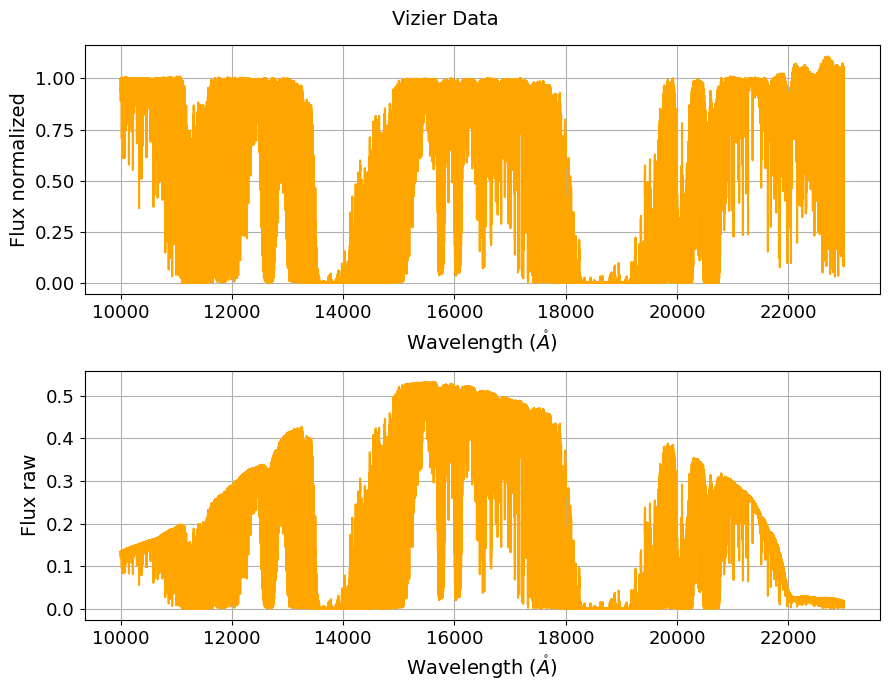

In [64]:
#Plot of raw data
fig1, axis1 = plt.subplots(2,1, figsize = (9, 7),)
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'Vizier Data',fontsize=14)

ax1.plot(raw_data['Wave A'],raw_data['nFlux'],color='orange')
ax1.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax1.set_ylabel('Flux normalized',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.plot(raw_data['Wave A'],raw_data['rFlux'],color='orange')
ax2.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax2.set_ylabel('Flux raw',fontsize=14)
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig1.tight_layout()

### Find the minimums and the closer line of the Fe I line


In [87]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Fe line
0,10022.532502,0.946571,10022.539000
1,10025.030255,0.957562,10025.035000
2,10035.604601,0.942222,10035.609000
3,10044.238228,0.918650,10044.224721
4,10060.417776,0.874610,10060.400000
...,...,...,...
434,21184.087003,0.900923,21183.949769
435,22085.890807,1.001544,22085.893364
436,22111.476788,0.808269,22111.536783
437,22391.190649,0.902154,22391.216195


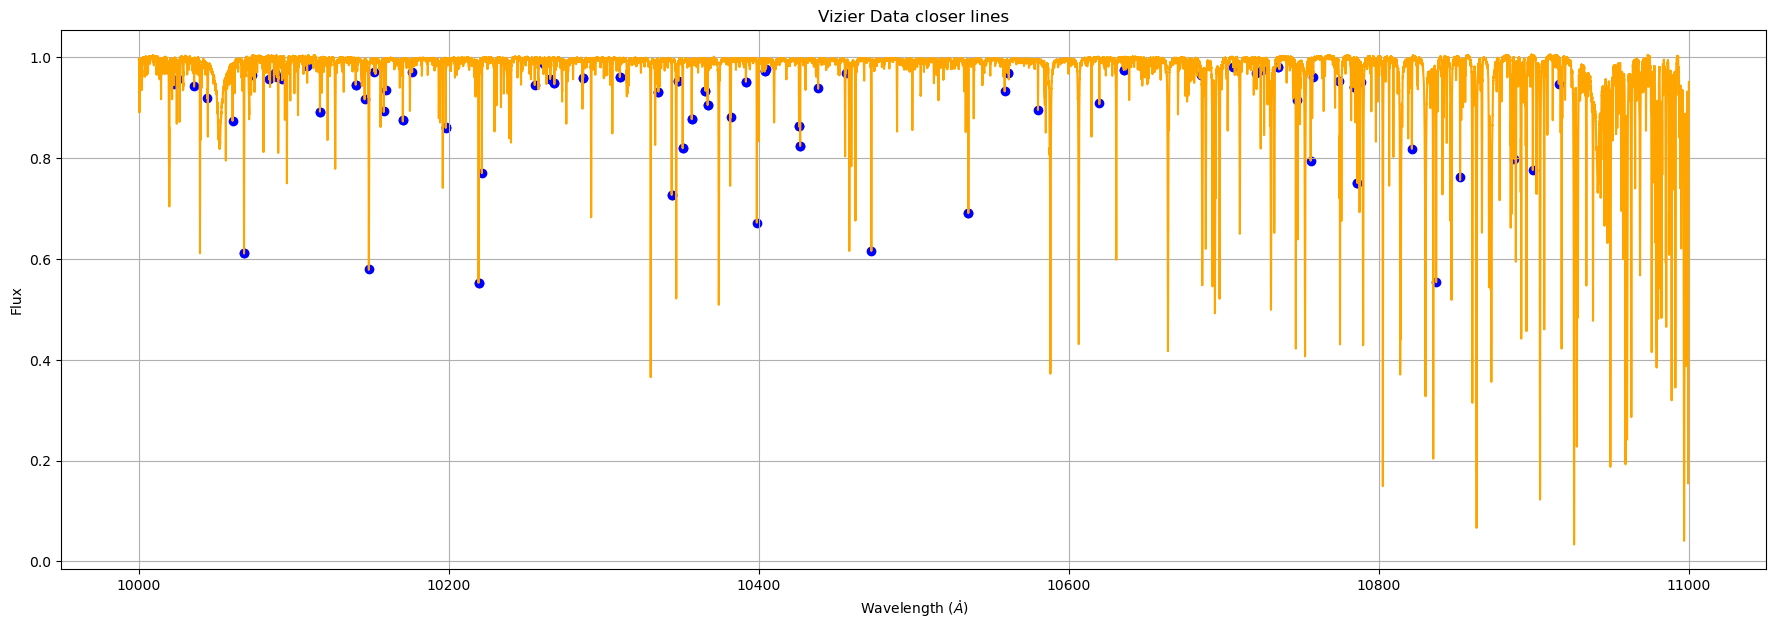

In [66]:
#Plot the identified lines
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)
closer_lines_10000_11000 = closer_lines[closer_lines['Fe line'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)

fig2, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(data_10000_11000['Wave A'],data_10000_11000['nFlux'], color='orange')
ax.scatter(closer_lines_10000_11000['min_wave'],closer_lines_10000_11000['min_flux'], color='blue')
ax.set_title('Vizier Data closer lines')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

In [80]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points


local_points = width_minimums(closer_lines,raw_data,0.05)


### Derivates and fit

In [82]:
def Fit_derivates(local_points,lamda_list):
    values = []
    fit = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0:

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))

            #Evaluate the second and third derivate in the wavelength observed
            d2 = poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2) #Re-scalated the coefficients
            d3 = Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) ) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, second derivate, third derivate, convective blueshift
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2,d3,blueshift]])) 

            #Just in case of the visualizer take the fit values
            fit.append(flux_fit)

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","2nd Derivate","3rd Derivate","Blueshift"]


    return Values,fit

Values,fit = Fit_derivates(local_points,closer_lines['Fe line'])

Values = Values[Values['Flux']>0]



## Visualizer for Fe I lines with the fit

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\clauw\AppData\Local\Temp\ipykernel_31248\1216218688.py", line 68, in on_slider_move
    self.update_plot()
  File "C:\Users\clauw\AppData\Local\Temp\ipykernel_31248\1216218688.py", line 110, in update_plot
    self.ax.plot(
  File "c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py", line 1777, in plot
    lines = [*self._get_lines(self, *args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\axes\_base.py", line 297, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\axes\_base.py", line 494, in _plot_args
    raise ValueError(f"x and y must have same first dimension, 

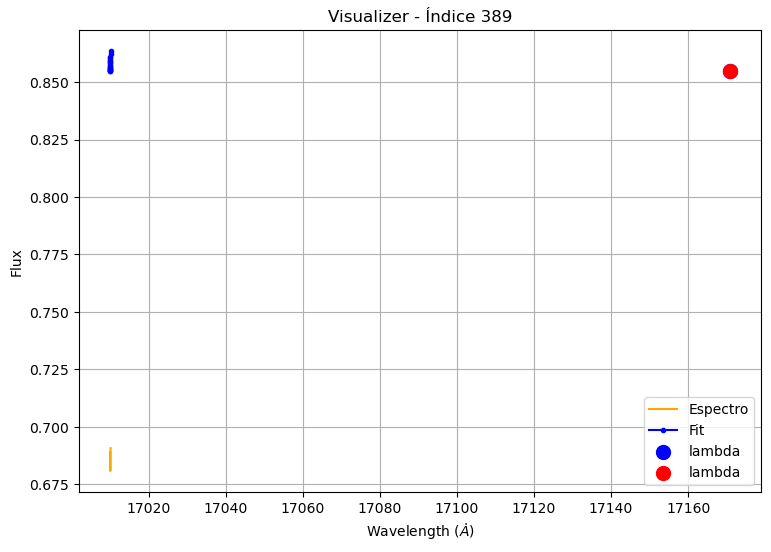

In [83]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import numpy as np

class OutlierViewer:
    def __init__(self, root, local_points, values,fit):
        self.root = root
        self.root.title("Visualizador Interactivo de Outliers")
        self.local_points = local_points
        self.values = values
        self.fit = fit
        self.index = values.index.values
        self.current_index = 0
       
        self.setup_ui()
        self.update_plot()
    
    def setup_ui(self):
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        control_frame = ttk.Frame(main_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(control_frame, text="Índice de Outlier:").pack(side=tk.LEFT, padx=5)
        self.slider = ttk.Scale(
            control_frame,
            from_=0,
            to=len(self.index)-1,
            orient=tk.HORIZONTAL,
            command=self.on_slider_move
        )
        self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
        self.spinbox = ttk.Spinbox(
            control_frame,
            from_=0,
            to=len(self.index)-1,
            width=5,
            command=self.on_spinbox_change
        )
        self.spinbox.pack(side=tk.LEFT, padx=5)
        self.spinbox.bind("<Return>", self.on_spinbox_change)
        
        nav_frame = ttk.Frame(control_frame)
        nav_frame.pack(side=tk.LEFT, padx=10)
        
        ttk.Button(nav_frame, text="← Anterior", command=self.prev_plot).pack(side=tk.LEFT)
        ttk.Button(nav_frame, text="Siguiente →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
        graph_frame = ttk.Frame(main_frame)
        graph_frame.pack(fill=tk.BOTH, expand=True)
       
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
        self.toolbar.update()
        self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
    
    def on_slider_move(self, event=None):
        self.current_index = int(float(self.slider.get()))
        self.spinbox.delete(0, tk.END)
        self.spinbox.insert(0, str(self.current_index))
        self.update_plot()
    
    def on_spinbox_change(self, event=None):
        try:
            new_index = int(self.spinbox.get())
            if 0 <= new_index < len(self.index):
                self.current_index = new_index
                self.slider.set(self.current_index)
                self.update_plot()
        except ValueError:
            pass
    
    def prev_plot(self):
        if self.current_index > 0:
            self.current_index -= 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
    
    def next_plot(self):
        if self.current_index < len(self.index)-1:
            self.current_index += 1
            self.slider.set(self.current_index)
            self.spinbox.delete(0, tk.END)
            self.spinbox.insert(0, str(self.current_index))
            self.update_plot()
    
    #Graficas
    def update_plot(self):
        j = self.current_index
        self.ax.clear()
        
        # Gráfica principal
        self.ax.plot(
            self.local_points[j]['Wave A'],
            self.local_points[j]['nFlux'],
            color='orange',
            label='Espectro'
        )
        
        #Closer lines
        self.ax.plot(
            self.local_points[j]['Wave A'],
            self.fit[j],
            color='blue',
            label='Fit',
            marker='.',
        )
        
        #Punto regresion
        self.ax.scatter(
            self.values["Observed wavelength"][j],
            self.values['Flux'][j],
            color='blue',
            label='lambda',
            s=100
        )

        #Puntos de la lista de Fe
        self.ax.scatter(
            self.values["Emitted wavelength"][j],
            self.values['Flux'][j],
            color='red',
            label='lambda',
            s=100
        )
        
        #Vainitas del gráfico
        self.ax.set_title(f'Visualizer - Índice {self.index[j]}')
        self.ax.set_xlabel(r'Wavelength $(\mathring{A})$')
        self.ax.set_ylabel('Flux')
        self.ax.legend()
        self.ax.grid(True)
        
        self.canvas.draw()


if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("900x700")

    app = OutlierViewer(root, local_points, Values,fit)

    root.mainloop()

In [53]:
##Convert to excel
# Values.to_excel('valores_NIR.xlsx', index=False)

## Graphics 
As we have an absorption spectrum, the line depth is measurement one minus the flux value.

### Velocity vs Normalized Flux

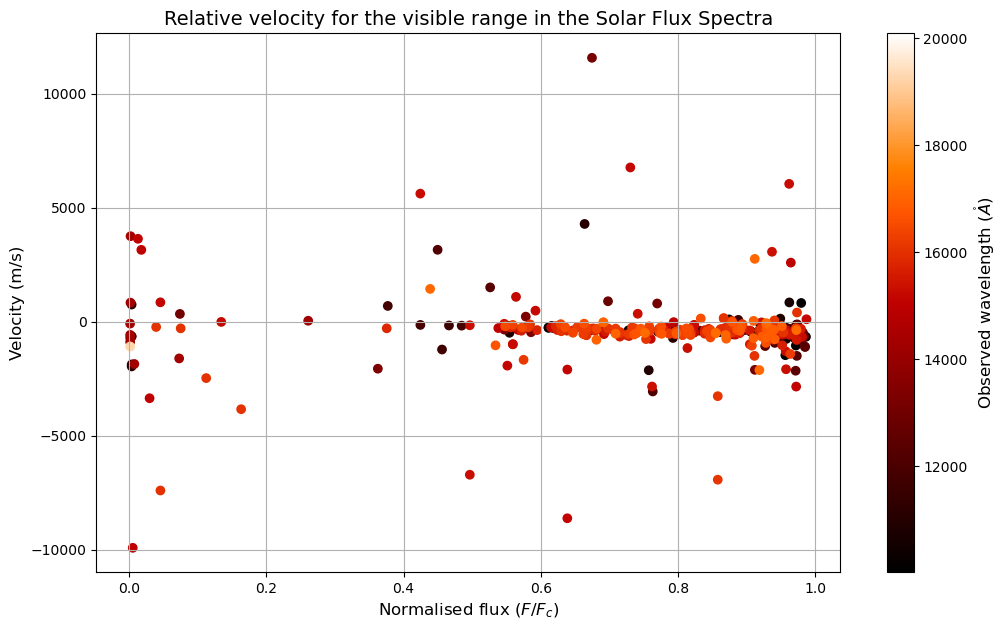

In [84]:
fig3, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Velocity'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Relative velocity for the visible range in the Solar Flux Spectra',fontsize=14)
ax.set_xlabel(r'Normalised flux $(F/F_{c})$', fontsize=12)
ax.set_ylabel('Velocity (m/s)', fontsize=12)
ax.grid()

# fig3.savefig('Velocity.png')

(-0.2, 50.0)

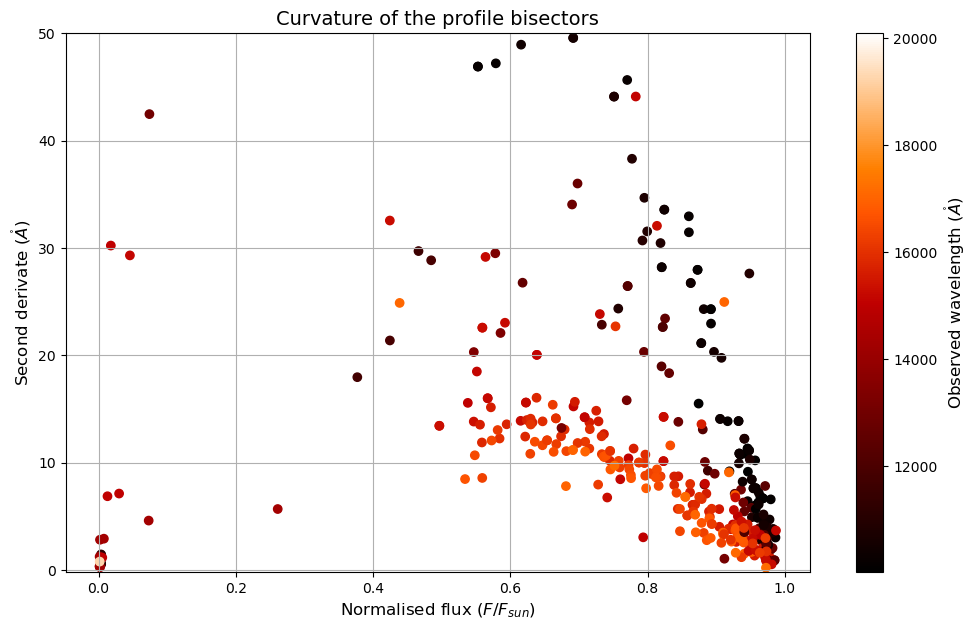

In [71]:
fig4, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['2nd Derivate'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Curvature of the profile bisectors',fontsize=14)
ax.set_xlabel(r'Normalised flux $(F/F_{sun})$',fontsize=12)
ax.set_ylabel(r'Second derivate $(\mathring{A})$',fontsize=12)
ax.grid()
ax.set_ylim(-0.2,50)

# fig4.savefig('Curvature.png')

### Third Derivate Expresion vs Normalized Flux

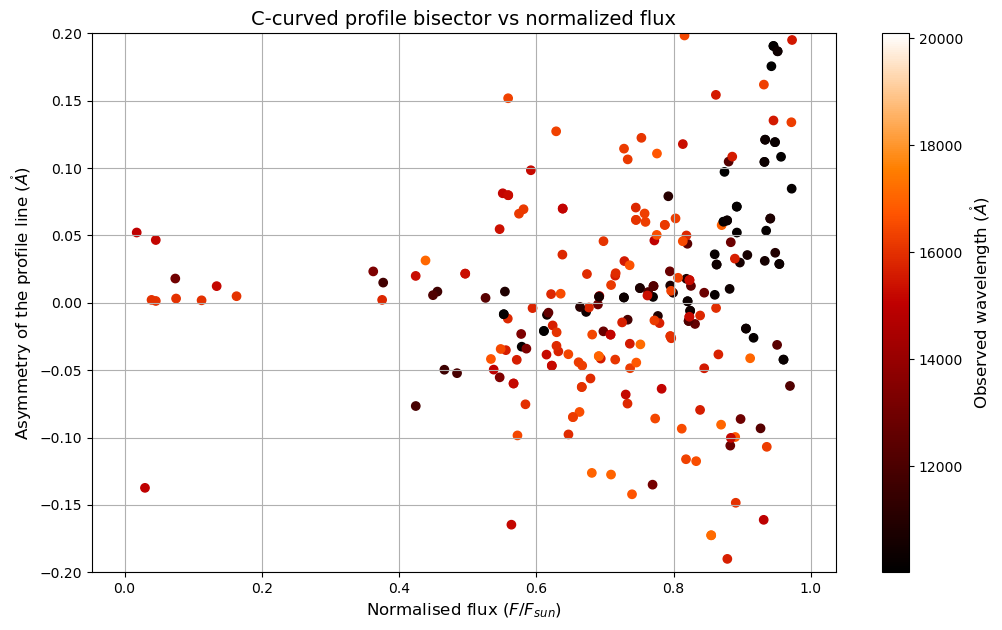

In [72]:
fig5, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['3rd Derivate'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('C-curved profile bisector vs normalized flux',fontsize=14)
ax.set_xlabel(r'Normalised flux $(F/F_{sun})$',fontsize=12)
ax.set_ylabel(r'Asymmetry of the profile line $(\mathring{A})$',fontsize=12)
ax.set_ylim(-0.2,0.2)
ax.grid()

# fig5.savefig('CBisector.png')

### Convective Blueshift vs Line Depth

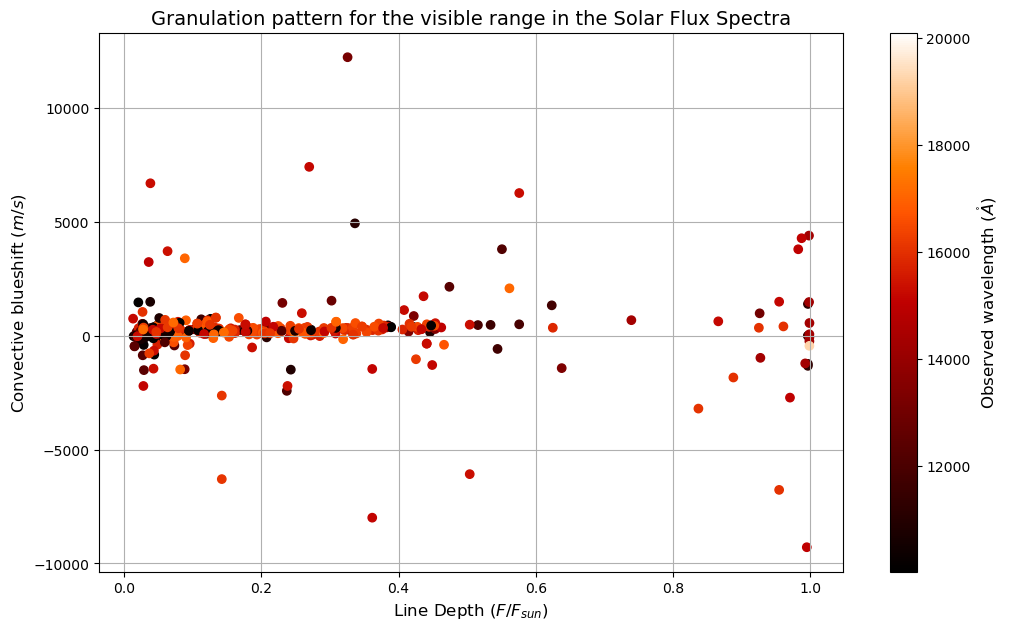

In [73]:
fig6, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(1-Values['Flux'],Values['Blueshift'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Granulation pattern for the visible range in the Solar Flux Spectra',fontsize=14)
ax.set_xlabel(r'Line Depth $(F/F_{sun})$',fontsize=12)
ax.set_ylabel(r'Convective blueshift $(m/s)$',fontsize=12)
ax.grid()

# fig6.savefig('ConvectiveBlueshift.png')